In [1]:
# note that the package multiprocess is on purpose instead of multiprocessing 
# multiprocess is a fork which works with jupyter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import multiprocess as mp
import time
import os
import warnings
import logging
import io
import csv
import sys
from datetime import datetime
import logging

In [4]:
from qfin.utils import bs_iv, bs_explicit_call, bs_explicit_put
from qfin.models import *
from qfin.plot import plot_smiles, plot_points
from qfin.volsurf import VolatilitySurface
from qfin.volsurf.filters import *
from qfin.calibration import calibrate

In [5]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [99]:
MULTIPROCESSING = True
DATES = 1000
filters = [filter_delta(0.25), filter_volume(10)]

# Calibration

In [103]:
directory = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")
directory

In [180]:
# KAPPA, RHO, V0, VBAR, XI, LAMBDA, MU_Y, SIGMA_Y, MU_V
reg = np.array([2e-4, 1e-2, 1e-3, 1e-3, 1e-3, 1e-3, 1e-2, 5e-4, 0])

models = [
    (BlackScholesModel, np.array([1.]), np.diag([0.])),
    (HestonModel, np.array([3., -0.1, 0.8, 0.8, 1.]), np.diag(reg[:5])),
    (VarianceGammaModel, np.array([0.01, 0.8, -0.6]), np.diag([0, 0, 0.])),
    (SVJModel, np.array([3., -0.1, 0.8, 0.8, 1., 1., 0., 0.1]), np.diag(reg[:8])),
    (SVCJModel, np.array([3., -0.1, 0.8, 0.8, 1., 1., 0., 0.1, 0.01]), np.diag(reg[:9])),
    (CGMYModel, np.array([10., 10., 10., 0.7]), np.diag([0., 0., 0., 0.])),
    (MertonModel, np.array([0.01, 0., 1., 0.8]), np.diag([*reg[5:8], 0])),
]

In [174]:
dates = sorted([item[:8] for item in os.listdir("_input/tickers") if item.endswith('.csv')])
dates = dates[:DATES]
# dates = ["20200204", "20200318"]

In [175]:
def calibrate_day(date, model, x0, reg, filters):
    
    t0 = time.time()
    
    dt = datetime.strptime(date, "%Y%m%d")
    market_vs = VolatilitySurface.from_date(dt, filters=filters)
    calibration_path = f"_output/calibration/results/{directory}/{model.name}/calibration/{date}.csv"

    with open(calibration_path, "w") as stream:
        result = calibrate(model, market_vs, x0, reg, stream=stream)
    
    dt = time.time() - t0
    
    parameters_path = f"_output/calibration/results/{directory}/{model.name}/parameters.csv"

    # output parameters
    with open(parameters_path, 'a+') as f:
        ps = ",".join(["{:.6f}"] * len(result['x'])).format(*result['x'])
        f.write(f"{date},{result['fun']},{result['rmse']},{result['penalty']},{ps}\n")

    errors_path = f"_output/calibration/results/{directory}/{model.name}/errors/{date}.csv"

    # output errors
    model_vs = model.vs(result['x'], market_vs.points)
    
    # create rows
    df1 = model_vs.data.set_index(['ttm', 'moneyness'])
    df2 = market_vs.data.set_index(['ttm', 'moneyness'])
    rows = [[idx[0], idx[1], df1.loc[idx, 'iv'], df2.loc[idx, 'iv']] for idx in df1.index]
    
    # create df
    df = pd.DataFrame(rows, columns=['ttm', 'moneyness', 'model_iv', 'market_iv'])
    df['diff'] = np.abs(df['model_iv'] - df['market_iv'])
    df.to_csv(errors_path, index=False)

    return model.name, date, result['x'], result['fun'], dt

In [ ]:
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    
    results = []
    
    def callback(retval):
        model_name, date, parameters, rmse, dt = retval
        results.append([model_name, date, rmse, *parameters])
        progress = len(results) / len(dates)
        print(f"\r{model_name:20} {progress:7.2%} {dt:7.2f}s", end='')

    for cls, x, reg in models:
        
        print(f"\r{cls.name:20} {0:7.2%}", end='')

        # take other model parameters as initial value x0
        if cls == HestonModel or cls == MertonModel or cls == VarianceGammaModel:
            df = pd.read_csv(f'_output/calibration/results/{directory}/BLACK_SCHOLES/parameters.csv')
        elif cls == SVJModel:
            df = pd.read_csv(f'_output/calibration/results/{directory}/HESTON/parameters.csv')
        elif cls == SVCJModel:
            df = pd.read_csv(f'_output/calibration/results/{directory}/SVJ/parameters.csv')
                            
        os.makedirs(f"_output/calibration/results/{directory}/{cls.name}/errors", exist_ok=True)
        os.makedirs(f"_output/calibration/results/{directory}/{cls.name}/calibration", exist_ok=True)
        
        parameters_path = f"_output/calibration/results/{directory}/{cls.name}/parameters.csv"
        
        with open(parameters_path, 'w') as f:
            ps = ",".join(cls.labels)
            f.write(f"date,cost,rmse,penalty,{ps}\n")

        all_args = []
            
        for date in dates:
            
            x0 = x[:]
            
            try:
                if cls == BlackScholesModel:
                    # take min IV for BS
                    dt = datetime.strptime(date, "%Y%m%d")
                    market_vs = VolatilitySurface.from_date(dt, filters=filters)
                    x0 = np.min(market_vs.data['iv'])
                elif cls == HestonModel:
                    # take BS sigma**2 for HESTON parameters V0 and VBAR
                    bs_sigma = df.loc[df['date'] == int(date), 'SIGMA'].iloc[0]
                    x0[2] = x0[3] = bs_sigma ** 2
                elif cls == MertonModel:
                    # take BS sigma for MERTON
                    bs_sigma = df.loc[df['date'] == int(date), 'SIGMA'].iloc[0]
                    x0[3] = bs_sigma
                elif cls == VarianceGammaModel:
                    # take BS sigma for VARIANCE_GAMMA
                    bs_sigma = df.loc[df['date'] == int(date), 'SIGMA'].iloc[0]
                    x0[1] = bs_sigma
                elif cls == SVJModel:
                    # take Heston parameters for SVJ
                    heston_parameters = df.loc[df['date'] == int(date), ['KAPPA', 'RHO', 'V0', 'VBAR', 'XI']].iloc[0].to_list()
                    x0[0], x0[1], x0[2], x0[3], x0[4] = heston_parameters
                elif cls == SVCJModel:
                    # take SVJ parameters for SVCJ
                    x0[0], x0[1], x0[2], x0[3], x0[4], x0[5], x0[6], x0[7] = df.loc[df['date'] == int(date), ['KAPPA', 'RHO', 'V0', 'VBAR', 'XI', "LAMBDA", "MU_Y", "SIGMA_Y"]].iloc[0].to_list()
            except:
                pass
                        
            model = cls()
            all_args += [[date, model, x0, reg, filters]]

        if MULTIPROCESSING:
            
            p = mp.Pool(mp.cpu_count())

            for args in all_args:
                p.apply_async(calibrate_day, args=args, callback=callback)

            p.close()
            p.join()
            
        else:
            
            for args in all_args:
                callback(calibrate_day(*args))
        
        results = []
        
        print("")


inf {'SIGMA': 0.6403}


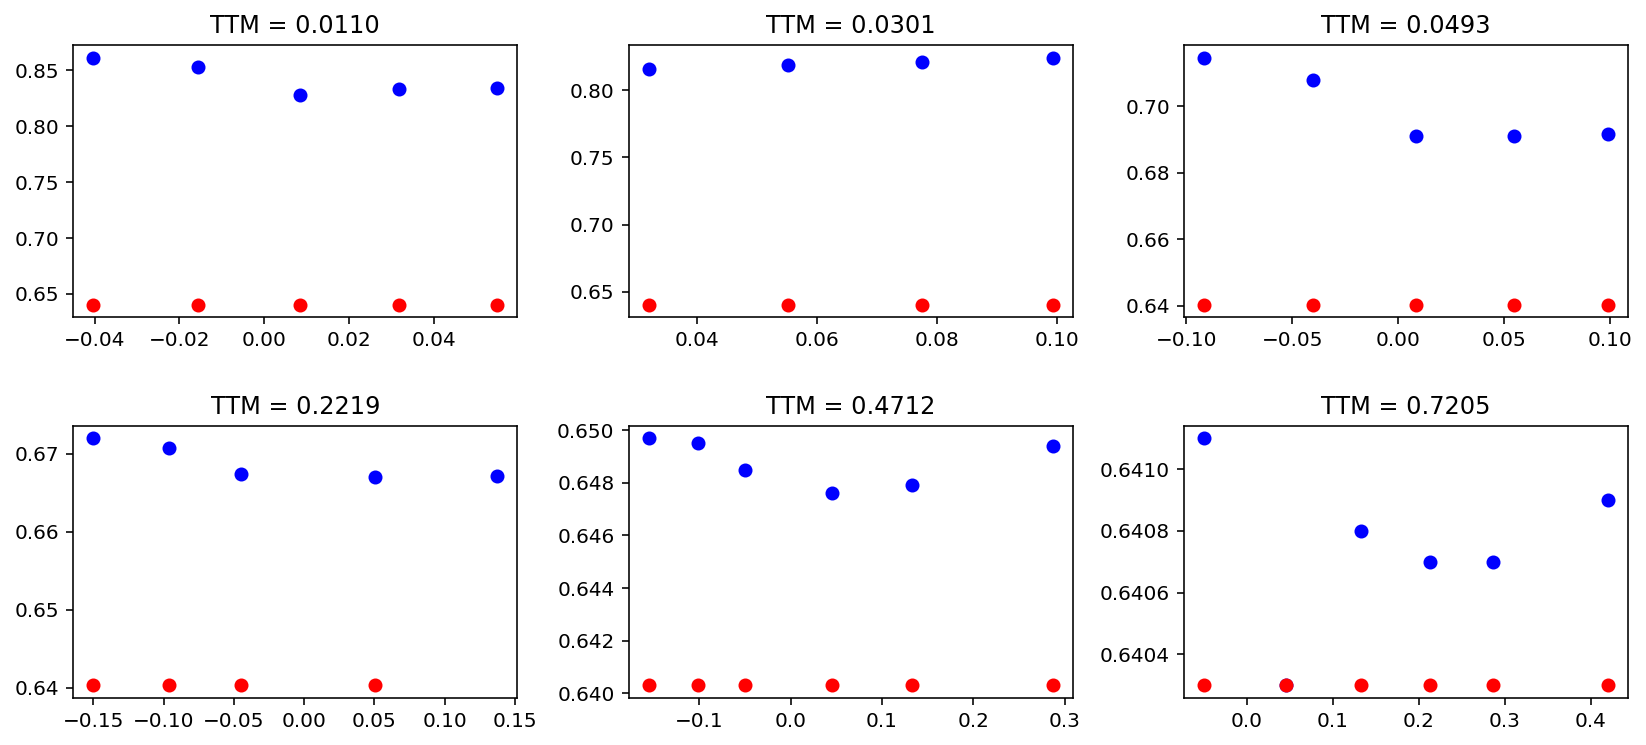

In [61]:
dt = datetime(2019, 4, 8)
directory = "20210227_121908"

market_vs = VolatilitySurface.from_date(dt, filters=[filter_delta(0.25), filter_volume(10)])
# market_vs.calibrate()
fig = market_vs.plot()

date = datetime.strftime(dt, "%Y%m%d")

models = [BlackScholesModel()]

for model in models:
    x0 = pd.read_csv(f"_output/calibration/results/{directory}/{model.name}/parameters.csv").set_index('date').loc[int(date), list(model.labels)].to_numpy()
    model_vs = model.vs(x0, market_vs.points)
    model_vs.name = model.name
#     model_vs.calibrate()
    _ = model_vs.plot(fig=fig)
    print(model_vs - market_vs, dict(zip(model.labels, x0)))
